# Load

## Libraries

In [1]:
%matplotlib notebook

In [31]:
import numpy as np
import itertools as it
import sklearn as skl
from sklearn import datasets

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Utilities

In [4]:
def labelXYZ(ax, xlabel, ylabel, zlabel=None, params={}):
    ax.set_xlabel(xlabel, **params)
    ax.set_ylabel(ylabel, **params)
    if zlabel:
        ax.set_zlabel(zlabel, **params)
    return ax

## Data
Choose one: Iris or Faces

In [11]:
iris = skl.datasets.load_iris()
X = iris.data # 150 samples by (petal length, petal width, sepal length, sepal width)
n,d = X.shape
Y = iris.target # 3 possible species

In [10]:
faces = skl.datasets.fetch_olivetti_faces()
X = faces.data
n,d = X.shape # d = 64x64
Y = faces.target

# Analysis

## Inspect SVD

In [12]:
U,S,Vt = np.linalg.svd(X - np.mean(X, axis=0))

<IPython.core.display.Javascript object>


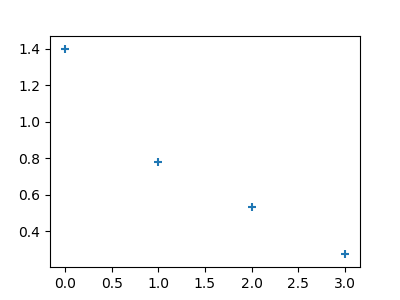

In [13]:
fig,ax = plt.subplots(1, figsize=[4,3])
ax.scatter(list(range(len(S))), np.log10(S), marker='+')

<IPython.core.display.Javascript object>


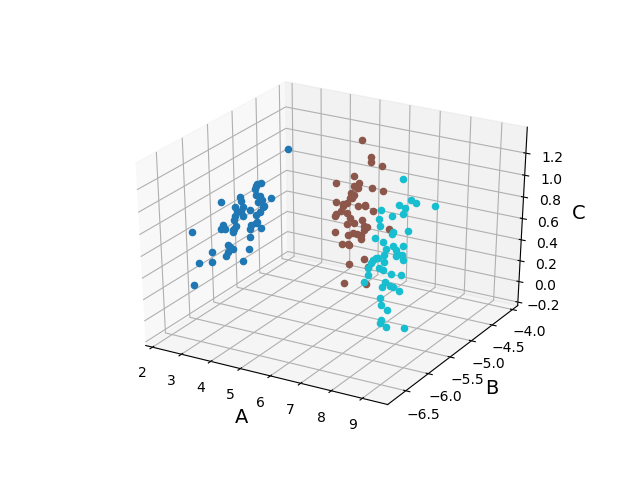

In [14]:
fig= plt.figure()
ax = fig.add_subplot(111, projection='3d')
pcX = X@Vt.T[:,:3]
colors, cnorm = [mpl.cm.get_cmap('tab10'), np.max(Y)]
for i,j,k,c in zip(pcX[:,0], pcX[:,1], pcX[:,2],Y):
    ax.scatter(i,j,k,color=colors(c/cnorm))
labelXYZ(ax, 'A','B','C', {'fontsize': 14});

## Agglomerative clustering using minimax

### Utilities

In [65]:
def construct_distance_matrix(X):
    '''
    Construct a distance matrix D={i,j, d(x_i,x_j): for all x_i, x_j in X}. 
        The matrix is symmetric so we just compute distances for all combinations 
        of len(X) choose 2. Use the lookup function 'lookup_distance' to get distances.
        Currently, Euclidean distance is the fixed behavior.
    
    Arguments:
        X: A list of elements from which to construct the distance matrix
    '''
    return [[i,j,np.sum(np.square(X[i]-X[j]))] for i,j in it.combinations(range(len(X)),2)]

Every index k < i contributes the full size of the set $n_k = \{j: k<j \text{ and } j < n\}$.
\begin{equation*}
    \sum_{k=0}^{i-1} (n-1)-i = i(n-1) - n(n-1)/2
\end{equation*}
The difference $j-i-1$ is how far along in the set $n_i$ to go to find the desired distance.

In [216]:
def lookup_distance(i, j, distance_matrix, n_elems, equal_distance = 0):
    '''
    Every index k < i contributes the full size of the set n_k = {j: k<j & j < n}.
        The total is \sum_{k=0}^{i-1} (n-1)-i = i(n-1) - n(n-1)/2
        The difference j-i-1 is how far along in the set n_i to 
        go to find the desired distance.
        
    Arguments:
        i: index of distance matrix
        j: other index of distance matrix
        distance_matrix: matrix of distances written [x1, x2, d(x1,x2)],\
                         follows the structure set in construct_distance_matrix
        n_elems: number of points in the initial set creating distance_matrix
        equal_distance: (Default 0) Distance of equivalent elements.
    '''
    if i==j:
        return equal_distance
    elif i < j:
        # Look up the correct row:
        return distance_matrix[i*(n_elems-1)-i*(i-1)//2 + j-i-1][2]
    else:
        return lookup_distance(j,i,distance_matrix,n_elems,equal_distance)

In [220]:
# Sloppy test cases:
test_distance = [[i,j,(i,j)] for i,j in it.combinations(range(9),2)]
print('(5,8)?', lookup_distance(5,8,test_distance,9), lookup_distance(8,5,test_distance, 9))
print('0?', lookup_distance(5,5,test_distance, 9))

(5,8)? (5, 8) (5, 8)
0? 0


In [219]:
def find_nearest_neighbor(index, possible_neighbors, distance_matrix, n_elems):
    '''
    Return the nearest neighbor of index from the set of possible_neighbors
        using distance defined in distance_matrix (having n_elems in total).
    '''
    return min([[j,lookup_distance(index, j, distance_matrix, n_elems)] 
                for j in possible_neighbors if j != index],
               key=lambda x: x[1])[0]

### Algorithm

In [301]:
clustering = [[[i] for i in range(n)]] # iterations by list of sets
c_indices = list(range(n))

# Memory constraints might make pre-computing distances a problem (dismiss for now)
distance = construct_distance_matrix(X)

In [302]:
iteration = 0

# Chain can either contract to 0 or n-1 merges occur
chain = []

# Choose first entry of chain from available indices at the current iteration
chain.append(chain[0] if chain else np.random.choice(n-iteration))

In [303]:
# There are n-1-iteration neighbors available
for n_chainings in range(n-1-iteration):
    # Find the index of the closest entry
    neighbor = find_nearest_neighbor(chain[-1], c_indices, distance, n-iteration)

    if len(chain) > 1 and chain[-2] == neighbor:
        print('RNN')
        break
    else:
        chain.append(neighbor)

RNN


In [304]:
G1 = clustering[iteration][chain[-1]]
G2 = clustering[iteration][chain[-2]]
clustering.append([G1 + G2] + [i for i in clustering[iteration] if i not in [G1, G2]])

In [359]:
new_distance = []
for d in distance:
    d0 = d[0]
    d1 = d[1]
    
    # Skip removed entries
    if d0 in [chain[-1], chain[-2]]:
        continue
    if d1 in [chain[-1], chain[-2]]:
        continue
    
    # Correct indices for removed entries
    if d[0] > chain[-1]:
        d0 -= 1
    if d[0] > chain[-2]:
        d0 -= 1
    if d[1] > chain[-1]:
        d1 -= 1
    if d[1] > chain[-2]:
        d1 -= 1
    
    # Increment to make room for new entries
    d0 += 1
    d1 += 1
    
    new_distance.append([d0,d1,d[2]])

In [369]:
def minimax_distance(G, H, distance, n_elems):
    G_union_H = G + H # list of original indices
    best_center = -1
    best_center_r = np.inf
    for center in G_union_H:
        center_max_r = max([lookup_distance(center, j, distance, n_elems)
                           for j in G_union_H if j != center])
        if center_max_r < best_center_r:
            best_center_r = center_max_r
            best_center = center
    return [center_max_r, best_center]

In [366]:
# Iterate over every entry and compute new distance
# TODO: Change to n-iterations!
[[0, i, minimax_distance(G1+G2, H, distance, n)] for H in everybody_else]

[[0, 1, 'test'],
 [0, 2, 'test'],
 [0, 3, 'test'],
 [0, 4, 'test'],
 [0, 5, 'test'],
 [0, 6, 'test'],
 [0, 7, 'test'],
 [0, 8, 'test'],
 [0, 9, 'test'],
 [0, 10, 'test'],
 [0, 11, 'test'],
 [0, 12, 'test'],
 [0, 13, 'test'],
 [0, 14, 'test'],
 [0, 15, 'test'],
 [0, 16, 'test'],
 [0, 17, 'test'],
 [0, 18, 'test'],
 [0, 19, 'test'],
 [0, 20, 'test'],
 [0, 21, 'test'],
 [0, 22, 'test'],
 [0, 23, 'test'],
 [0, 24, 'test'],
 [0, 25, 'test'],
 [0, 26, 'test'],
 [0, 27, 'test'],
 [0, 28, 'test'],
 [0, 29, 'test'],
 [0, 30, 'test'],
 [0, 31, 'test'],
 [0, 32, 'test'],
 [0, 33, 'test'],
 [0, 34, 'test'],
 [0, 35, 'test'],
 [0, 36, 'test'],
 [0, 37, 'test'],
 [0, 38, 'test'],
 [0, 39, 'test'],
 [0, 40, 'test'],
 [0, 41, 'test'],
 [0, 42, 'test'],
 [0, 43, 'test'],
 [0, 44, 'test'],
 [0, 45, 'test'],
 [0, 46, 'test'],
 [0, 47, 'test'],
 [0, 48, 'test'],
 [0, 49, 'test'],
 [0, 50, 'test'],
 [0, 51, 'test'],
 [0, 52, 'test'],
 [0, 53, 'test'],
 [0, 54, 'test'],
 [0, 55, 'test'],
 [0, 56, 'test'],
 

In [371]:
G1+G2

[29, 30]

In [ ]:
update(i,j,linkage_list):
    k if k in [] for k in linkage_list